# Causal discovery with `TIGRAMITE`

TIGRAMITE is a time series analysis python module. It allows to reconstruct graphical models (conditional independence graphs) from discrete or continuously-valued time series based on the PCMCI method and create high-quality plots of the results.

PCMCI is described here:
J. Runge, P. Nowack, M. Kretschmer, S. Flaxman, D. Sejdinovic, 
Detecting and quantifying causal associations in large nonlinear time series datasets. Sci. Adv. 5, eaau4996 (2019) 
https://advances.sciencemag.org/content/5/11/eaau4996

This tutorial explains how to use PCMCI to obtain optimal predictors. See the following paper for theoretical background:
Runge, Jakob, Reik V. Donner, and Jürgen Kurths. 2015. “Optimal Model-Free Prediction from Multivariate Time Series.” Phys. Rev. E 91 (5): 052909. https://doi.org/10.1103/PhysRevE.91.052909.

Last, the following Nature Communications Perspective paper provides an overview of causal inference methods in general, identifies promising applications, and discusses methodological challenges (exemplified in Earth system sciences): 
https://www.nature.com/articles/s41467-019-10105-3

In [1]:
# Imports
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
from tigramite.models import LinearMediation, Prediction


# Prediction

Tigramite also contains a class ``tigramite.models.Prediction`` to perform predictions based on the sklearn models. The ``Prediction`` class includes a wrapper around ``run_pc_stable`` from the ``PCMCI`` class to perform predictor selection. Consider the following data generation process: 

In [2]:
np.random.seed(42)
T = 150
links_coeffs = {0: [((0, -1), 0.6)],
                1: [((1, -1), 0.6), ((0, -1), 0.8)],
                2: [((2, -1), 0.5), ((1, -1), 0.7)],  # ((0, -1), c)],
                }
N = len(links_coeffs)
data, true_parents = pp.var_process(links_coeffs, T=T)
dataframe = pp.DataFrame(data, var_names = [r'$X^0$', r'$X^1$', r'$X^2$', r'$X^3$'])

We initialize the ``Prediction`` class with ``cond_ind_model=ParCorr()``. Secondly, we choose ``sklearn.linear_model.LinearRegression()`` here for prediction. Last, we scale the data via ``data_transform``. The class takes care of rescaling the data for prediction. The parameters ``train_indices`` and ``test_indices`` are used to divide the data up into a training set and test set. The test set is optional since new data can be supplied later. The training set is used to select predictors and fit the model.

In [3]:
pred = Prediction(dataframe=dataframe,
        cond_ind_test=ParCorr(),   #CMIknn ParCorr
        prediction_model = sklearn.linear_model.LinearRegression(),
#         prediction_model = sklearn.gaussian_process.GaussianProcessRegressor(),
        # prediction_model = sklearn.neighbors.KNeighborsRegressor(),
    data_transform=sklearn.preprocessing.StandardScaler(),
    train_indices= range(int(0.8*T)),
    test_indices= range(int(0.8*T), T),
    verbosity=1
    )

Now, we estimate causal predictors using ``get_predictors`` for the target variable 2 taking into account a maximum past lag of ``tau_max``. We use ``pc_alpha=None`` which optimizes the parameter based on the Akaike score. Note that the predictors are different for each prediction horizon. For example, at a prediction horizon of ``steps_ahead=1`` we get the causal parents from the model plus some others:


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 5
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged condition sets:

    Variable 0 has 1 parent(s):
    [pc_alpha = 0.05]
        (0 -1): max_pval = 0.00000, min_val = 0.485

    Variable 1 has 3 parent(s):
    [pc_alpha = 0.3]
        (1 -1): max_pval = 0.00000, min_val = 0.671
        (0 -1): max_pval = 0.00000, min_val = 0.622
        (0 -4): max_pval = 0.24260, min_val = 0.113

    Variable 2 has 4 parent(s):
    [pc_alpha = 0.2]
        (2 -1): max_pval = 0.00000, min_val = 0.558
        (1 -1): max_pval = 0.00000, min_val = 0.467
        (0 -2): max_pval = 0.09687, min_val = 0.161
        (1 -2): max_pval = 0.11617, min_val = 0.152


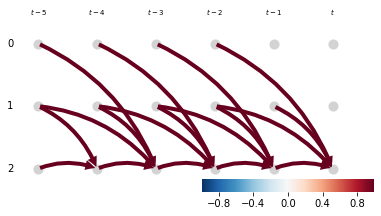

In [4]:
target = 2
tau_max = 5
predictors = pred.get_predictors(
                  selected_targets=[target],
                  steps_ahead=1,
                  tau_max=tau_max,
                  pc_alpha=None
                  )
link_matrix = np.zeros((N, N, tau_max+1), dtype='bool')
for j in [target]:
    for p in predictors[j]:
        link_matrix[p[0], j, abs(p[1])] = 1

# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
    val_matrix=np.ones(link_matrix.shape),
    link_matrix=link_matrix,
    var_names=None,
    link_colorbar_label='',
    )

Note, that ``get_predictors`` is based only on the first step of PCMCI and skips the MCI step since correct false positive rates are not that relevant for prediction and the first step alone is faster. Now, we set ``steps_ahead=2`` and get different predictors:


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 2
tau_max = 30
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged condition sets:

    Variable 0 has 6 parent(s):
    [pc_alpha = 0.5]
        (0 -26): max_pval = 0.13044, min_val = 0.199
        (0 -18): max_pval = 0.17469, min_val = 0.187
        (0 -14): max_pval = 0.26686, min_val = 0.146
        (2 -30): max_pval = 0.34987, min_val = 0.123
        (0 -29): max_pval = 0.39563, min_val = 0.114
        (2 -2): max_pval = 0.48642, min_val = 0.092

    Variable 1 has 9 parent(s):
    [pc_alpha = 0.5]
        (0 -2): max_pval = 0.00007, min_val = 0.494
        (0 -4): max_pval = 0.03531, min_val = 0.277
        (0 -27): max_pval = 0.09264, min_val = 0.221
        (2 -7): max_pval = 0.14074, min_val = 0.198
        (0 -15): max_pval = 0.22216, min_val = 0.165
        (0 -23): max_pval = 0.35496, min_val = 0.131
        (0 -24

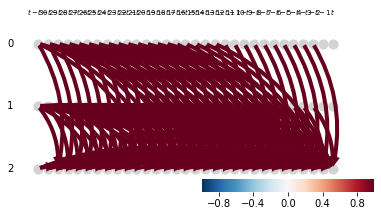

In [5]:
tau_max = 30
steps_ahead = 2
target = 2

all_predictors = pred.get_predictors(
                  selected_targets=[target],
                  steps_ahead=steps_ahead,
                  tau_max=tau_max,
                  pc_alpha=None
                  )
link_matrix = np.zeros((N, N, tau_max + 1), dtype='bool')
for j in [target]:
    for p in all_predictors[j]:
        link_matrix[p[0], j, abs(p[1])] = 1

# Plot time series graph
tp.plot_time_series_graph(
    figsize=(6, 3),
    val_matrix=np.ones(link_matrix.shape),
    link_matrix=link_matrix,
    var_names=None,
    link_colorbar_label='',
    )

These predictors now efficiently avoid overfitting in the following model fit. Here one can specify whether multiple target variables should be fit at once (assuming that for all of these predictors have been estimated beforehand).

In [6]:
pred.fit(target_predictors=all_predictors, 
                selected_targets=[target],
                    tau_max=tau_max)

Now we are ready to predict the target variable at the test samples:


##
## Predicting target 2
##


Text(0, 0.5, 'Predicted test data')

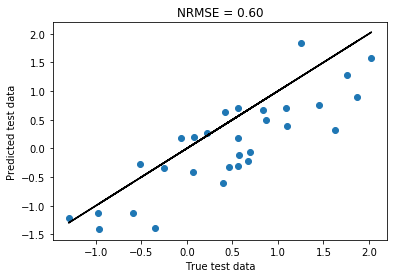

In [7]:
predicted = pred.predict(target)
true_data = pred.get_test_array()[0]

plt.scatter(true_data, predicted)
plt.title(r"NRMSE = %.2f" % (np.abs(true_data - predicted).mean()/true_data.std()))
plt.plot(true_data, true_data, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')

We can also predict other new data by supplying a new dataframe to ``new_data``. Because we have more samples here, the estimate of NRMSE is more reliable.


##
## Predicting target 2
##


Text(0, 0.5, 'Predicted test data')

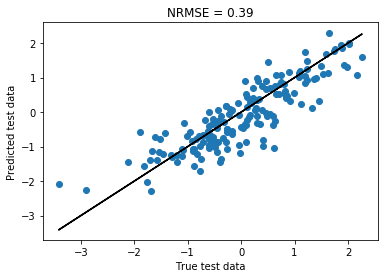

In [8]:
new_data = pp.DataFrame(pp.var_process(links_coeffs, T=200)[0])
predicted = pred.predict(target, new_data=new_data)
true_data = pred.get_test_array()[0]

plt.scatter(true_data, predicted)
plt.title(r"NRMSE = %.2f" % (np.abs(true_data - predicted).mean()/true_data.std()))
plt.plot(true_data, true_data, 'k-')
plt.xlabel('True test data')
plt.ylabel('Predicted test data')

This prediction is much better than using *all* past variables which leads to overfitting:


##
## Predicting target 2
##


Text(0, 0.5, 'Predicted test data')

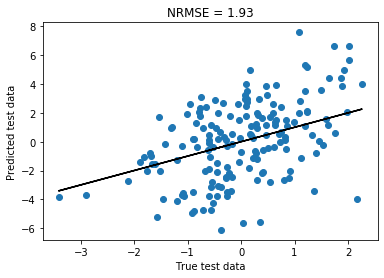

In [9]:
whole_predictors = {2:[(i, -tau) for i in range(3) for tau in range(1, tau_max+1)]}
pred.fit(target_predictors=whole_predictors, 
                selected_targets=[target],
                    tau_max=tau_max)

# new_data = pp.DataFrame(pp.var_process(links_coeffs, T=100)[0])
predicted = pred.predict(target, new_data=new_data)
# predicted = pred.predict(target)
true_data = pred.get_test_array()[0]

plt.scatter(true_data, predicted)
plt.plot(true_data, true_data, 'k-')
plt.title(r"NRMSE = %.2f" % (np.abs(true_data - predicted).mean()/true_data.std()))
plt.xlabel('True test data')
plt.ylabel('Predicted test data')


Before, we rescaled the data before fitting which requires us to also rescale the test data. We can also leave the data unscaled:


##
## Predicting target 2
##


Text(0, 0.5, 'Predicted test data')

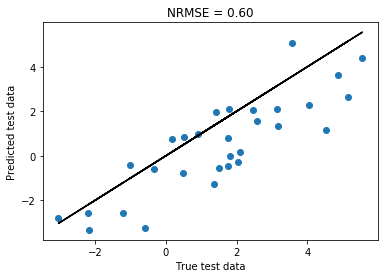

In [10]:
pred = Prediction(dataframe=dataframe,
        cond_ind_test=ParCorr(),
        prediction_model = sklearn.linear_model.LinearRegression(),
#     data_transform=sklearn.preprocessing.StandardScaler(),
    train_indices= range(int(0.8*T)),
    test_indices= range(int(0.8*T), T),
    verbosity=1
    )
pred.fit(target_predictors=all_predictors, 
                selected_targets=[target],
                    tau_max=tau_max)
predicted = pred.predict(target)
# predicted = pred.predict(target)
true_data = pred.get_test_array()[0]

plt.scatter(true_data, predicted)
plt.plot(true_data, true_data, 'k-')
plt.title(r"NRMSE = %.2f" % (np.abs(true_data - predicted).mean()/true_data.std()))
plt.xlabel('True test data')
plt.ylabel('Predicted test data')


Note the different scales on the x- and y-axes.

Last, let's try a Gaussian process regressor in conjunction with a GPDC predictor selection. Here we supply ``cond_ind_params`` and ``prediction_model_params`` because the sklearn defaults don't work well here.


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = gp_dc
tau_min = 2
tau_max = 10
pc_alpha = [0.2]
max_conds_dim = None
max_combinations = 1


Null distribution for GPDC not available for deg. of freed. = 380.

## Resulting lagged condition sets:

    Variable 0 has 2 parent(s):
        (0 -2): max_pval = 0.00000, min_val = 0.107
        (2 -3): max_pval = 0.19300, min_val = 0.008

    Variable 1 has 4 parent(s):
        (0 -2): max_pval = 0.00000, min_val = 0.285
        (1 -2): max_pval = 0.00000, min_val = 0.059
        (2 -7): max_pval = 0.14300, min_val = 0.009
        (0 -8): max_pval = 0.19800, min_val = 0.008

    Variable 2 has 4 parent(s):
        (1 -2): max_pval = 0.00000, min_val = 0.266
        (0 -2): max_pval = 0.00000, min_val = 0.112
        (2 -2): max_pval = 0.00000, min_val = 0.050
        (0 -4): max_pval = 0.13600, min_val = 0.010

##
## Predicting target 2
##


Text(0, 0.5, 'Predicted test data')

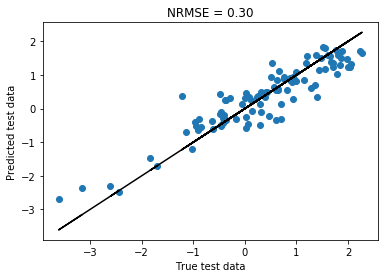

In [11]:
tau_max = 10
steps_ahead = 2
target = 2
T = 500
dataframe = pp.DataFrame(pp.var_process(links_coeffs, T=T)[0])
pred = Prediction(dataframe=dataframe,
        cond_ind_test=GPDC(),   #CMIknn ParCorr
        prediction_model = sklearn.gaussian_process.GaussianProcessRegressor(alpha=0., kernel=sklearn.gaussian_process.kernels.RBF() +
                                        sklearn.gaussian_process.kernels.WhiteKernel()),
        # prediction_model = sklearn.neighbors.KNeighborsRegressor(),
    data_transform=sklearn.preprocessing.StandardScaler(),
    train_indices= range(int(0.8*T)),
    test_indices= range(int(0.8*T), T),
    verbosity=1
    )

all_predictors = pred.get_predictors(
                  selected_targets=[target],
                  steps_ahead=steps_ahead,
                  tau_max=tau_max,
                  pc_alpha=0.2
                  )
pred.fit(target_predictors=all_predictors, 
                selected_targets=[target],
                    tau_max=tau_max)
predicted = pred.predict(target)
# predicted = pred.predict(target)
true_data = pred.get_test_array()[0]

plt.scatter(true_data, predicted)
plt.plot(true_data, true_data, 'k-')
plt.title(r"NRMSE = %.2f" % (np.abs(true_data - predicted).mean()/true_data.std()))
plt.xlabel('True test data')
plt.ylabel('Predicted test data')
